In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from termcolor import colored
from enum import Enum

from __future__ import print_function
import sys, os, time, pickle, rospy

from enum import Enum
from torobo_driver import torobo_easy_command

import numpy as np
from scipy import signal
import scipy

from sensor_msgs.msg import Image
from cv_bridge import CvBridge, CvBridgeError
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# wrapper/helper functions
sys.path.insert(0, '/home/torobo/catkin_ws/src/torobo_robot/torobo_rnn/scripts')
sys.path.insert(0, '/home/torobo/catkin_ws/src/tutorial/PyTorch-YOLOv3')

image_topic = "/camera/color/image_raw" # Real-Robot

from torobo_rnn_utils__upd3 import *
from detect_upd import Recog, Recog2
# from adjustExtForce_v3Controller import ExtForce

plt.switch_backend('nbAgg')

bridge = CvBridge()
torobo = ToroboOperator()

""" SET DYNAMICS PARAMETERS FOR THE ***POSITION*** REGIME  """
torobo.set_control_mode(ToroboOperator.TORSO_HEAD, 'all', 'position')
torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'position')
torobo.set_control_mode(ToroboOperator.RIGHT_ARM, 'all', 'position')
time.sleep(4)

set_softness_override(torobo, 10.0)
set_velocity_override(torobo, 10.0)
time.sleep(1)

[INFO] [1597815012.033169]: set_control_mode service client is called
[INFO] [1597815012.037150]: set_control_mode [['all']] is succeeded
[INFO] [1597815012.037845]: set_control_mode service client is called
[INFO] [1597815012.040633]: set_control_mode [['all']] is succeeded
[INFO] [1597815012.041250]: set_control_mode service client is called
[INFO] [1597815012.043835]: set_control_mode [['all']] is succeeded
[INFO] [1597815016.044974]: set_robot_controller_parameter service client is called
[INFO] [1597815016.046485]: set [softness_override, ['10.0'], ['all']] is succeeded
[INFO] [1597815016.046735]: set_robot_controller_parameter service client is called
[INFO] [1597815016.047991]: set [softness_override, ['10.0'], ['all']] is succeeded
[INFO] [1597815016.048296]: set_robot_controller_parameter service client is called
[INFO] [1597815016.049549]: set [softness_override, ['10.0'], ['all']] is succeeded
[INFO] [1597815016.049827]: set_robot_controller_parameter service client is calle

In [4]:
# # """ SET DYNAMICS PARAMETERS FOR THE ***EXTERNAL FORCE FOLLOWING*** REGIME  """
torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'external_force_following');
torobo.set_control_mode(ToroboOperator.RIGHT_ARM, 'all', 'external_force_following');

[INFO] [1597727593.161600]: set_control_mode service client is called
[INFO] [1597727593.165629]: set_control_mode [['all']] is succeeded
[INFO] [1597727593.166494]: set_control_mode service client is called
[INFO] [1597727593.170452]: set_control_mode [['all']] is succeeded


In [3]:
# torobo._ToroboOperator__JOINT_NAME_LIST

{0: ['left_arm/joint_1',
  'left_arm/joint_2',
  'left_arm/joint_3',
  'left_arm/joint_4',
  'left_arm/joint_5',
  'left_arm/joint_6'],
 1: ['right_arm/joint_1',
  'right_arm/joint_2',
  'right_arm/joint_3',
  'right_arm/joint_4',
  'right_arm/joint_5',
  'right_arm/joint_6'],
 2: ['torso_head/joint_1',
  'torso_head/joint_2',
  'torso_head/joint_3',
  'torso_head/joint_4'],
 3: ['left_gripper/finger_joint'],
 4: ['right_gripper/finger_joint']}

In [2]:
torobo.set_control_mode(ToroboOperator.LEFT_ARM,
                        'all',
                        'external_force_following_online_trajectory')

torobo.set_control_mode(ToroboOperator.RIGHT_ARM,
                        'all',
                        'external_force_following_online_trajectory')

torobo.set_control_mode(ToroboOperator.TORSO_HEAD,
                        ['torso_head/joint_3', 'torso_head/joint_4'],
                        'external_force_following_online_trajectory')

[INFO] [1597815017.067842]: set_control_mode service client is called
[INFO] [1597815017.070027]: set_control_mode [['all']] is succeeded
[INFO] [1597815017.070452]: set_control_mode service client is called
[INFO] [1597815017.072272]: set_control_mode [['all']] is succeeded
[INFO] [1597815017.072659]: set_control_mode service client is called
[INFO] [1597815017.074254]: set_control_mode [['torso_head/joint_3', 'torso_head/joint_4']] is succeeded


In [3]:
with open('rad.pickle', 'rb') as f:
    RAD = pickle.load(f)

In [4]:
# move_homepos(torobo)

# with open('rad.pickle', 'rb') as f:
#     RAD = pickle.load(f)
# ANG = []
# ts = time.time()

# idx = 0
# TIME = 1

# left_arm_positions = RAD[idx][0:6]
# right_arm_positions = RAD[idx][6:12]
# torso_head_positions = RAD[idx][12:16]

# torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
# torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
# torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
# rospy.sleep(TIME+0.1)
# ANG.append((idx, time.time() - ts))

# idx = 1
# TIME = 2

# left_arm_positions = RAD[idx][0:6]
# right_arm_positions = RAD[idx][6:12]
# torso_head_positions = RAD[idx][12:16]

# torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
# torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
# torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
# rospy.sleep(TIME+0.1)
# ANG.append((idx, time.time() - ts))

# idx = 2
# TIME = 3

# left_arm_positions = RAD[idx][0:6]
# right_arm_positions = RAD[idx][6:12]
# torso_head_positions = RAD[idx][12:16]

# torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
# torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
# torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
# rospy.sleep(TIME+0.1)
# ANG.append((idx, time.time() - ts))

# idx = 3
# TIME = 4

# left_arm_positions = RAD[idx][0:6]
# right_arm_positions = RAD[idx][6:12]
# torso_head_positions = RAD[idx][12:16]

# torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
# torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
# torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
# rospy.sleep(TIME+0.1)
# ANG.append((idx, time.time() - ts))

# idx = 4
# TIME = 3

# left_arm_positions = RAD[idx][0:6]
# right_arm_positions = RAD[idx][6:12]
# torso_head_positions = RAD[idx][12:16]

# torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
# torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
# torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
# rospy.sleep(TIME+0.1)
# ANG.append((idx, time.time() - ts))

In [5]:
# idx = 3
# TIME = 6

# left_arm_positions = RAD[idx][0:6]
# right_arm_positions = RAD[idx][6:12]
# torso_head_positions = RAD[idx][12:16]

# torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
# torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
# torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
# rospy.sleep(TIME+0.1)

In [10]:
# Go Home
with HiddenPrints():
    servo_on(torobo)

    idx = 4
    TIME = 6

    set_softness_override(torobo, 10.0)
    set_velocity_override(torobo, 10.0)

    with open('rad.pickle', 'rb') as f:
        RAD = pickle.load(f)

    left_arm_positions = RAD[idx][0:6]
    right_arm_positions = RAD[idx][6:12]
    torso_head_positions = RAD[idx][12:16]

    torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
    torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
    torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
    rospy.sleep(TIME+0.1)
pos, vel = get_cur_joints(torobo)

In [11]:
# fname = '/home/torobo/catkin_ws/src/tutorial/src/joints/DS_no track_3 ds/DS_no tracking 3 ds.dat'
fname = 'DS.dat'


with open(fname, 'rb') as f:
    dat = pickle.load(f)
    
IMG = dat['img']
joints = dat['joints']
times = dat['t']

start_idx = np.argmin(np.abs(dat['t']-0.0))
stop_idx = np.argmin(np.abs(dat['t']-194.12))

IMG = dat['img'][start_idx:stop_idx, :,:,:]
joints = dat['joints'][start_idx:stop_idx, :]
times = dat['t'][start_idx:stop_idx]



joints /= 4.0

img = np.stack(IMG)
img = img.transpose(0,3,1,2) #B x C x H x W
img = img[:,0,:,:]           # select only the red channel
img = img[:,None, :,:]       # squeeze the tensor
visual_input = torch.tensor(img, dtype=torch.float).cuda()

# prepare visual targets (they should be the same as the inputs only one step ahead)
visual_target = np.roll(img, -1, axis=0)
visual_target = torch.tensor(visual_target, dtype=torch.float).cuda()

motor_input = torch.tensor(joints, dtype=torch.float).cuda()

target_joints = np.roll(joints, -1, axis=0)
motor_target = torch.tensor(target_joints, dtype=torch.float).cuda()


In [12]:
from RNN import RNN, vaeRNN


input_size  = 46
hidden_size = 46
output_size = 46
cell_type = 'GRU'

criterion = nn.MSELoss()

rnn = RNN(cell_type, input_size, hidden_size, output_size).cuda() #noVAE
# rnn = vaeRNN(cell_type, input_size, hidden_size, output_size, False).cuda()

# rnn.load_state_dict(torch.load('checkpoint_ww'))
# rnn.load_state_dict(torch.load('checkpoint_ss'))
rnn.load_state_dict(torch.load('checkpoint_overnight_90_10')) # BEST
# rnn.load_state_dict(torch.load('checkpoint_vaeRNN_1K_iter_noBIG_mse'))
# rnn.load_state_dict(torch.load('checkpoint_vaeRNN_400K_iter_noBIG_mse'))

# rnn.load_state_dict(torch.load('checkpoint'))



<All keys matched successfully>

In [13]:
if not 'imagebuff' in locals():
    imagebuff = 0
    def image_callback(msg):
        global imagebuff
        imagebuff = bridge.imgmsg_to_cv2(msg, "rgb8") 
    rospy.Subscriber("/camera/color/image_raw", Image, image_callback)

cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

while True:
    cv2.imshow('I see', cv2.cvtColor(imagebuff, cv2.COLOR_RGB2BGR))
    k = cv2.waitKey(3) & 0XFF
    if k== 27 :
        cv2.destroyWindow('I see')
        break

In [14]:
pos, vel = get_cur_joints(torobo)

In [15]:
""" New steps are based on previously predicted ones """
tracking = True
device = 'cuda'

cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

hidden = rnn.initHidden(device)
starting_point = 0


DUR = 0.10


x = cv2.resize(np.copy(imagebuff), (64, 64), interpolation = cv2.INTER_AREA)
y = torch.tensor(x[:,:,0], dtype=torch.float).view(1,1,64,64).cuda()

# for plain RNN
visual_output, motor_output, hidden = rnn(y, 
                                  motor_input[starting_point,:].unsqueeze_(0),
                                  hidden)

# for vaeRNN
# visual_output, motor_output, hidden, mu, logsig = rnn(y, 
#                                                       motor_input[starting_point,:].unsqueeze_(0), 
#                                                       hidden, True)


OUT = motor_output.cpu().detach().numpy() * 4.0

left_arm_positions = OUT.reshape(1, 16)[0, 0:6]
right_arm_positions = OUT.reshape(1, 16)[0, 6:12]
torso_head_positions = OUT.reshape(1, 16)[0, 12:16]
torso_head_positions[0:2] = RAD[4][12:14]

torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=DUR+0.01)
torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=DUR+0.01)
if tracking:
    torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=DUR+0.01)
rospy.sleep(DUR)

OOO, FF = [], []
for i in range(1, visual_input.shape[0]):
      
    im1 = cv2.resize(visual_input[i,:,:].squeeze().cpu().detach().numpy(), (350, 350), interpolation = cv2.INTER_AREA)
    im1 = cv2.normalize(im1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    x = cv2.resize(np.copy(imagebuff), (64, 64), interpolation = cv2.INTER_AREA)
    y = torch.tensor(x[:,:,0], dtype=torch.float).view(1,1,64,64).cuda()
    
#     visual_output, motor_output, hidden = rnn(y, 
#                                   motor_output.view(1,-1),
#                                   hidden)
    
    mixed_motor = (0.5 * torch.tensor(np.radians(pos)/4.0, dtype=torch.float).cuda().view(1,-1) +
                   0.5 * motor_output.view(1, -1))

    visual_output, motor_output, hidden = rnn(y, mixed_motor, hidden)

# for vaeRNN
#     visual_output, motor_output, hidden, mu, logsig = rnn(y, 
#                                   motor_output.view(1,-1),
#                                   hidden, True)
    
    im2 = cv2.resize(visual_output.squeeze().cpu().detach().numpy(), (350, 350), interpolation = cv2.INTER_AREA)
    im2 = cv2.normalize(im2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    im3 = cv2.resize(imagebuff, (350, 350), interpolation = cv2.INTER_AREA)
    im3 = cv2.normalize(im3, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    final_frame = cv2.hconcat((im3[:,:,2], im2))
    cv2.imshow('I see', final_frame)
    FF.append(final_frame)

    k = cv2.waitKey(3) & 0XFF
    if k== 27 :
        cv2.destroyWindow('I see')
        break
    i += 1
        
    OUT = motor_output.cpu().detach().numpy() * 4.0

    left_arm_positions = OUT.reshape(1, 16)[0, 0:6]
    right_arm_positions = OUT.reshape(1, 16)[0, 6:12]
    if tracking:
        torso_head_positions = OUT.reshape(1, 16)[0, 12:16]              # !!!!!!!!!!!!!!!!!!!!!!!!!!
        torso_head_positions[0:2] = RAD[4][12:14]

    torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=DUR+0.01)
    torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=DUR+0.01)
    if tracking:
        torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=DUR+0.01)
    rospy.sleep(DUR)
    
    
    pos, vel = get_cur_joints(torobo)
    OOO.append((np.radians(pos), motor_output.cpu().detach().numpy() * 4.0))


[WARN] [1597815629.430654]: [move_arm] trajectory is canceled due to collision
[WARN] [1597815629.434258]: [move_arm] trajectory is canceled due to collision
[WARN] [1597815708.429965]: [move_arm] trajectory is canceled due to collision
[WARN] [1597815708.434124]: [move_arm] trajectory is canceled due to collision


In [16]:
import imageio
imageio.mimwrite('output_filename.mp4', np.stack(FF) , fps=10)

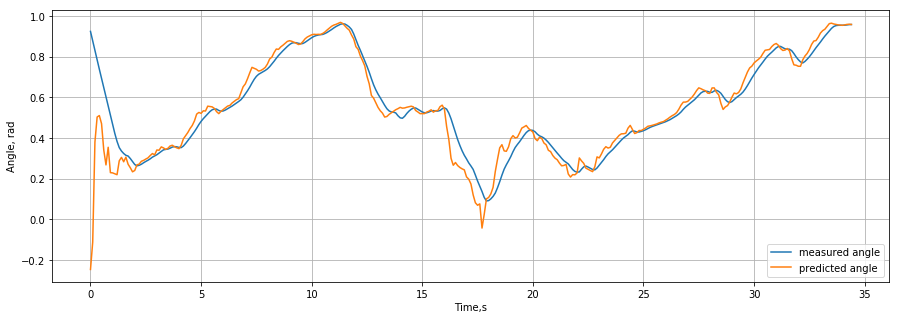

In [14]:
%matplotlib inline
joint = 0


gt = [line[0][joint] for line in OOO]
pred = [line[1][joint] for line in OOO]

t = np.arange(0, len(OOO)/10.0, 0.1)
plt.figure(figsize=(15,5))
plt.plot(t, gt, label='measured angle')
plt.plot(t, pred, label='predicted angle')
plt.grid()
plt.xlabel('Time,s')
plt.ylabel('Angle, rad')
plt.legend()




In [21]:
DUR = 4
torso_head_positions = np.array([0, np.radians(40), 0, np.radians(20)])
torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=DUR+0.05)

In [22]:
""" New steps NOT based on previously predicted ones """

hidden = rnn.initHidden()
starting_point = 0
DUR = 0.2


for i in range(visual_input.shape[0]):
    
    visual_output, motor_output, hidden = rnn(visual_input[i,:,:,].unsqueeze_(0), 
                                  motor_input[i,:].view(1,-1),
                                  hidden)
    
    OUT = motor_output.cpu().detach().numpy() * 4.0

    left_arm_positions = OUT[0:6]
    right_arm_positions = OUT[6:12]
    torso_head_positions = OUT[12:16]

    torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=DUR+0.05)
    torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=DUR+0.05)
    torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=DUR+0.05)
    rospy.sleep(DUR)

TypeError: initHidden() takes exactly 2 arguments (1 given)